<a href="https://colab.research.google.com/github/calicartels/XAI-adversarial-patch/blob/main/Adversarial_patch_vishnu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ResNet34 pretrained on ImageNet
model = models.resnet34(weights='IMAGENET1K_V1').to(device)
model.eval()

# Load ImageNet class names
with open('imagenet_classes.txt') as f:
    class_names = [line.strip() for line in f.readlines()]


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 187MB/s]


In [ ]:
# Image preprocessing function
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Loading and preprocessing the image
def load_image(image_path):
    img = Image.open(image_path)
    img_tensor = preprocess(img).unsqueeze(0)
    return img_tensor.to(device)

# Choosing my class: banana
banana_image_path = '/content/how-many-calories-are-in-a-banana-1440x810.jpg'
clean_image = load_image(banana_image_path)


In [ ]:
# FGSM attack
def fgsm_attack(image, epsilon, data_grad):
    # Get the sign of the gradients
    sign_data_grad = data_grad.sign()
    # Perturbing the image by epsilon
    perturbed_image = image + epsilon * sign_data_grad
    # Clipping the image to stay within pixel range [0, 1]
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

# Applying FGSM to generate an adversarial patch
def generate_adversarial_patch(model, image, target_class_idx, epsilon=0.07):
    image.requires_grad = True

    # Forward pass
    output = model(image)

    # Defining the target label
    target = torch.tensor([target_class_idx], device=device)

    # Calculating the loss between the output and the target label
    loss = F.cross_entropy(output, target)

    # Zero all existing gradients
    model.zero_grad()

    # Performing backward pass
    loss.backward()

    # Collecting the gradients of the image
    data_grad = image.grad.data

    # Applying FSGM to generate the adversarial patch
    perturbed_image = fgsm_attack(image, epsilon, data_grad)

    return perturbed_image


banana_class_idx = class_names.index('banana')

# Generate the adversarial image with FGSM
epsilon = 0.7
adv_image = generate_adversarial_patch(model, clean_image, banana_class_idx, epsilon)


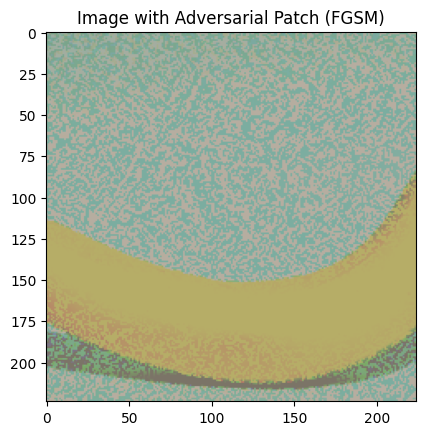

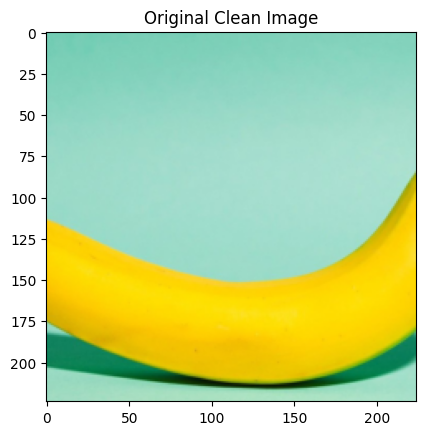

In [ ]:
# Function to unnormalize and display images
def imshow(tensor, title):
    tensor = tensor.cpu().clone()
    tensor = tensor.squeeze(0)     # Remove batch dimension
    tensor = tensor.permute(1, 2, 0)
    tensor = tensor * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Unnormalize
    tensor = torch.clamp(tensor, 0, 1)
    plt.imshow(tensor)
    plt.title(title)
    plt.show()

# Display the adversarial image
imshow(adv_image.detach(), title="Image with Adversarial Patch (FGSM)")

# Display the original clean image for comparison
imshow(clean_image.detach(), title="Original Clean Image")


In [ ]:
# Correct function to get both prediction and confidence score
def get_prediction_with_confidence(image, model, class_names):
    model.eval()
    with torch.no_grad():
        output = model(image)
        # Apply softmax to get the confidence scores
        probabilities = F.softmax(output, dim=1)
        # Get the predicted index
        _, predicted_idx = output.max(1)
        predicted_class = class_names[predicted_idx.item()]
        confidence = probabilities[0, predicted_idx.item()].item()
    return predicted_class, confidence


In [ ]:
# Prediction and confidence of the original image
clean_prediction, clean_confidence = get_prediction_with_confidence(clean_image, model, class_names)
print(f"Prediction for clean image: {clean_prediction} (Confidence: {clean_confidence * 100:.2f}%)")


Prediction for clean image: banana (Confidence: 99.30%)


In [ ]:
# Prediction and confidence of the perturbed image
adv_prediction, adv_confidence = get_prediction_with_confidence(adv_image, model, class_names)
print(f"Prediction for adversarial image: {adv_prediction} (Confidence: {adv_confidence * 100:.2f}%)")


Prediction for adversarial image: bib (Confidence: 69.04%)
